# Travel Insurance Prediction
[Dataset Link](https://www.kaggle.com/datasets/tejashvi14/travel-insurance-prediction-data)

*Predict Whether A Customer Will Be Interested In Buying Travel Insurance*

# Introduction
Let's assume a role of a Travel Insurance specialist for a US-based airline. The Bird Flu has been circulating around the media, raising anxiety among the population and travelers. Your company decided to use this situation for testing a brand new travel insurance plan that includes a "Bird Flu package" that covers medical, quarantine expenses and reimbursements in the case of bird flu. Your task is to use the Travel Insurance Prediction dataset from an Indian company that provided a "Covid package" for its customers to try and predict the success of the "Bird Flu package" in the US.

## Context
The study will perform the following steps:
1. Explore the data - distributions, correlations & significance of IV-DV relationships.
2. Feature selection - identify key customer properties for statistical modeling.
3. Statistical model - create a classification model to predict whether the customer would buy the travel insurance package or not.

## Summary
* `Age` and `FamilyMembers` seemed to have a large impact on travel insurance purchasing.
* Statistical significance tests have shown that `FrequentFlyer`, `EverTravelledAbroad` and income level are all significant predictors for travel insurance purchasing.
* Developed a Logistic Regression Model with an accuracy of 82%, yet not a very great recall for insurance buyers.

# Data Preparation
## Imports & Configuration

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from sklearn.svm import SVC
import statsmodels.api as sm
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.proportion import confint_proportions_2indep
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.kernel_approximation import Nystroem


from utils import chi_squared_test, visualize_performance

In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
color_palette = sns.color_palette('colorblind')
sns.set_style('whitegrid', {'axes.grid' : False})

In [3]:
df = pd.read_csv('data/TravelInsurancePrediction.csv', index_col=0)
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


## Data Formatting & Cleaning
Remove spaces in column names.

In [4]:
df.columns = df.columns.str.replace(' ', '')

Check the columns' datatypes.

In [5]:
print("DataFrame data types:")
df.dtypes

DataFrame data types:


Age                     int64
EmploymentType         object
GraduateOrNot          object
AnnualIncome            int64
FamilyMembers           int64
ChronicDiseases         int64
FrequentFlyer          object
EverTravelledAbroad    object
TravelInsurance         int64
dtype: object

Check for missing values.

In [6]:
missing_rows_count = df.isnull().any(axis=1).sum()
print(f"Rows with missing values: {missing_rows_count}")

Rows with missing values: 0


Check for duplicate rows.

In [7]:
duplicate_count = df.duplicated().sum()
print(f"Total rows: {len(df)}")
print(f"Duplicate rows: {duplicate_count}")
duplicates = df[df.duplicated(keep=False)]
sorted_duplicates = duplicates.sort_values(by=list(df.columns))
sorted_duplicates[:10]

Total rows: 1987
Duplicate rows: 738


,Age,EmploymentType,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
184,25,Government Sector,Yes,750000,3,0,No,No,0
724,25,Government Sector,Yes,750000,3,0,No,No,0
629,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1013,25,Private Sector/Self Employed,No,600000,4,0,Yes,No,0
1898,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
1905,25,Private Sector/Self Employed,No,600000,4,1,Yes,No,0
359,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1315,25,Private Sector/Self Employed,No,1150000,3,0,No,No,0
1633,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0
1645,25,Private Sector/Self Employed,No,1150000,3,0,Yes,No,0


More than a third of the dataset was flagged as duplicate rows. This might be normal if the Travel Insurance company within India applies to a specific sub-population of travelers. Even so, we do not have a lot of features in the dataset & some of the features are binary; Similarities among different customers may very well occur. For that reason, let's leave the whole dataset intact.

For convenience, let's convert the `AnnualIncome` from Indian Rupees to USD. [The 2019 average INR-USD exchange rate was 70.4059](https://www.exchangerates.org.uk/USD-INR-spot-exchange-rates-history-2019.html)

In [8]:
df['AnnualIncomeUSD'] = df['AnnualIncome'] / 70.4059
df.drop('AnnualIncome', axis=1, inplace=True)

Finally, let's convert Categorical variables into binary variables.

In [9]:
df['EverTravelledAbroad'] = df['EverTravelledAbroad'].map({'Yes': 1, 'No': 0})
df['GraduateOrNot'] = df['GraduateOrNot'].map({'Yes': 1, 'No': 0})
df['FrequentFlyer'] = df['FrequentFlyer'].map({'Yes': 1, 'No': 0})
df['GovernmentEmployee'] = df['EmploymentType'].map({'Government Sector': 1, 'Private Sector/Self Employed': 0})
df.drop('EmploymentType', axis=1, inplace=True)
df.head()

,Age,GraduateOrNot,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,AnnualIncomeUSD,GovernmentEmployee
0,31,1,6,1,0,0,0,5681.342047,1
1,31,1,7,0,0,0,0,17754.193896,0
2,34,1,4,1,0,0,1,7101.677558,0
3,28,1,3,1,0,0,0,9942.348582,0
4,28,1,8,1,1,0,0,9942.348582,0


# Exploratory Data Analysis
## Numeric Variables

Summarize the numeric variables to get the picture of the distribution of data & check for outliers.

In [10]:
numeric_variables = ['Age', 'FamilyMembers', 'AnnualIncomeUSD']
df[numeric_variables].describe(include='number').round(2)

,Age,FamilyMembers,AnnualIncomeUSD
count,1987.00,1987.00,1987.00
mean,29.65,4.75,13248.36
std,2.91,1.61,5352.62
min,25.00,2.00,4261.01
25%,28.00,4.00,8522.01
50%,29.00,5.00,12783.02
75%,32.00,6.00,17754.19
max,35.00,9.00,25566.04


Observations:
* As suspected with the duplicate rows situation, the customer base for the company is pretty narrow, with the customers being **from 25 to 35 years old**.
* The annual income shows signs of having outliers.

We'll summarize binary variables in EDA.

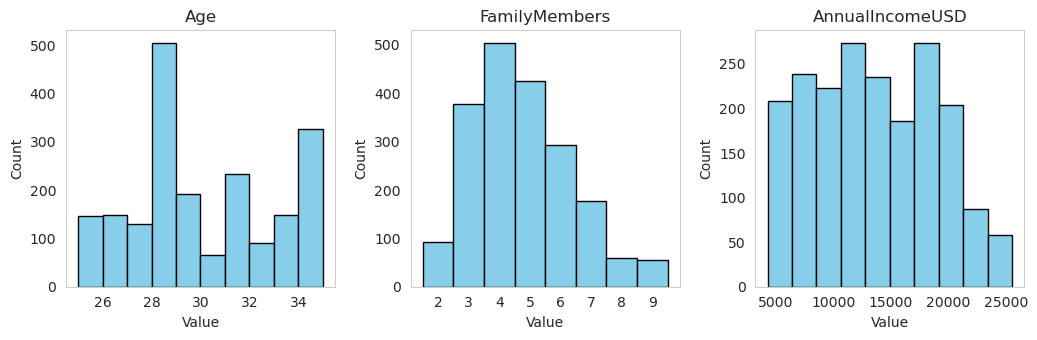

In [11]:
numeric_variables = ['Age', 'FamilyMembers', 'AnnualIncomeUSD']
cols = len(numeric_variables)

fig, axes = plt.subplots(nrows=1, ncols=cols, figsize=(cols*3.5, 3.5))

for i, col in enumerate(numeric_variables):
    if col == 'FamilyMembers':
        bins = np.arange(df[col].min() - 0.5, df[col].max() + 1.5, 1)
    else:
        bins = 10
    
    axes[i].hist(df[col], bins=bins, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')
    
    # For all columns, set x-ticks to the center of bins
    if col == 'FamilyMembers':
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        axes[i].set_xticks(bin_centers)
        axes[i].set_xticklabels([str(int(center)) for center in bin_centers])

plt.tight_layout()
plt.show()

Neither numerical column is normally distributed; The `FamilyMembers` distribution is slightly right skewed.
## Binary Variables

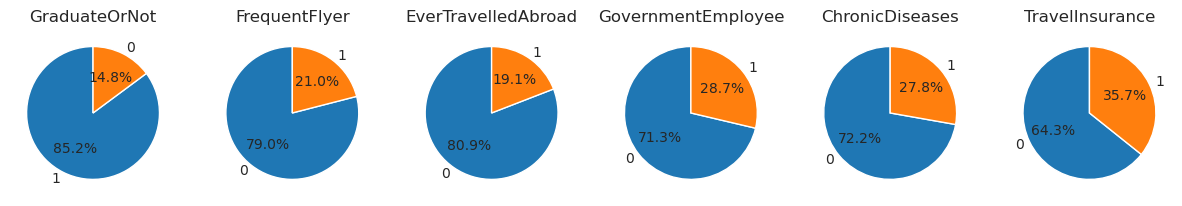

In [12]:
binary_variables = ['GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad', 'GovernmentEmployee', 'ChronicDiseases', 'TravelInsurance']
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(15, 10))

for i, col in enumerate(binary_variables):
    ax = axes[i]
    counts = df[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    ax.set_title(col)

Observations:

* 85% of the customers have a higher education degree;
* Only about 20% of the customers are frequent flyers or travelled abroad;
* Less than a third of the customers have a chronic disease;
* About 36% of the customers bought the travel insurnace.

## Correlation of Variables

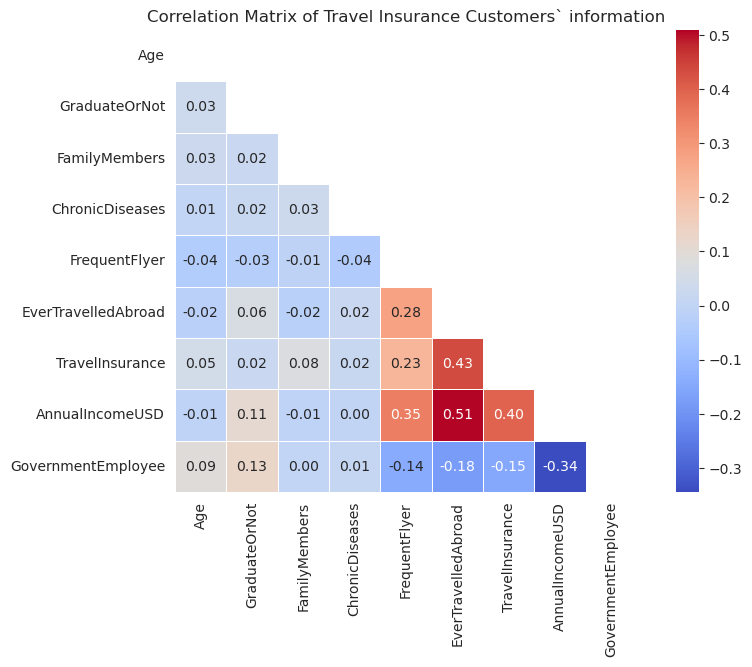

In [13]:
corr_matrix = df.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(10, 6))
labels = corr_matrix.map(lambda v: v if v else '')
sns.heatmap(corr_matrix, mask=mask, annot=labels, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Matrix of Travel Insurance Customers` information')
plt.show()

Positive correlations (>0.3):
* `EverTravelledAbroad` - `AnnualIncomeUSD`: Larger income would generally allow people to travel abroad.
* `FrequentFlyer` - `AnnualIncomeUSD`: Larger income would generally allow people to travel more often.
* `EverTravelledAbroad` - `TravelInsurance`: Travellers abroad seemed to buy travel insurance more frequently.
* `AnnualIncomeUSD` - `TravelInsurance`: Travellers with larger income seemed to buy travel insurance more frequently.

Negative correlations (<-0.3):
* `GovernmentEmployee` - `AnnualIncomeUSD`: Government workers seem to earn less.

With regards to our dependent variable `TravelInsurance`, only `FrequentFlyer`, `EverTravelledAbroad` and `AnnualIncomeUSD` seemed to show weak to moderate correlation.

Let's check for multicollinearity between variables through the **Variance Inflation Factor (VIF)**.

## Testing for Multicollinearity

In [14]:
X = df.drop(['TravelInsurance'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

               feature        VIF
0                  Age  19.682363
1        GraduateOrNot   6.902967
2        FamilyMembers   9.193303
3      ChronicDiseases   1.388028
4        FrequentFlyer   1.482726
5  EverTravelledAbroad   1.641000
6      AnnualIncomeUSD  10.694230
7   GovernmentEmployee   1.670108


`AnnualIncomeUSD`, `Age` and `FamilyMembers` variables have a high VIF. Since we are building a model to predict the success for a US-based customer base & the economic context is very different between the two countries, let's remove the `AnnualIncomeUSD` column, but create a separate feature `IncomeLevel` which classifies the income of the customer.

In [15]:
# Calculate the quantiles
low_threshold = df['AnnualIncomeUSD'].quantile(0.33)
high_threshold = df['AnnualIncomeUSD'].quantile(0.66)

# Define a function to categorize income
def categorize_income(income):
    if income <= low_threshold:
        return 'Low'
    elif income <= high_threshold:
        return 'Medium'
    else:
        return 'High'

# Apply the function to create the 'IncomeLevel' column
df['IncomeLevel'] = df['AnnualIncomeUSD'].apply(categorize_income)
df.drop('AnnualIncomeUSD', axis=1, inplace=True)
# One-Hot Encode the 'IncomeLevel' column
df = pd.get_dummies(df, columns=['IncomeLevel'], drop_first=True)
for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)

df.head()

,Age,GraduateOrNot,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance,GovernmentEmployee,IncomeLevel_Low,IncomeLevel_Medium
0,31,1,6,1,0,0,0,1,1,0
1,31,1,7,0,0,0,0,0,0,0
2,34,1,4,1,0,0,1,0,1,0
3,28,1,3,1,0,0,0,0,1,0
4,28,1,8,1,1,0,0,0,1,0


In [16]:
X = df.drop(['TravelInsurance'], axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

               feature        VIF
0                  Age  18.887270
1        GraduateOrNot   6.709334
2        FamilyMembers   9.197039
3      ChronicDiseases   1.389212
4        FrequentFlyer   1.408454
5  EverTravelledAbroad   1.768611
6   GovernmentEmployee   1.572219
7      IncomeLevel_Low   2.833583
8   IncomeLevel_Medium   2.737283


After removing income, we still have two variables `Age` and `FamilyMembers` that have a high VIF; Strangely enough, the variables do not show significant correlation to other variables in the correlation matrix, so there might be a non-linear relationship between `Age` and `Family Members` or with other variables.

To solve this potential problem, we will use **regularization** techniques to handle multicollinearity.
Additionally, let's check for feature importances. We will create train and test datasets.

In [17]:
X = df.drop(['TravelInsurance'], axis=1)
y = df['TravelInsurance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98)

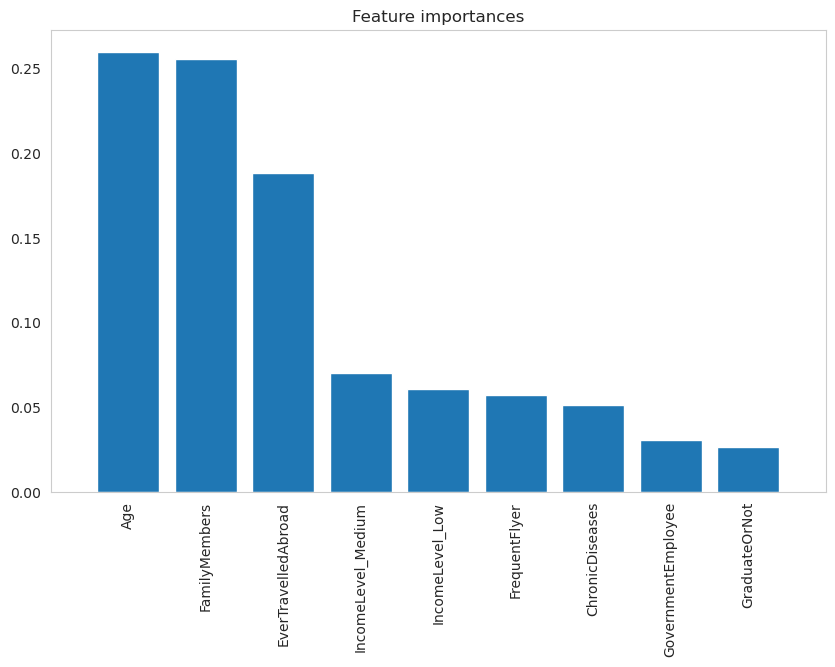

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

`Age` and `FamilyMembers` have a very high feature importance. To see if higher values of these variables determine whether the customers buy travel insurance, let's look at the direction and magnitude of their coefficients in a logistic regression model.

In [19]:
X_logit = df[['Age', 'FamilyMembers']]
y = df['TravelInsurance']

X_logit = sm.add_constant(X_logit)
logit_model = sm.Logit(y, X_logit).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.646946
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        TravelInsurance   No. Observations:                 1987
Model:                          Logit   Df Residuals:                     1984
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Jun 2024   Pseudo R-squ.:                0.007542
Time:                        13:59:41   Log-Likelihood:                -1285.5
converged:                       True   LL-Null:                       -1295.3
Covariance Type:            nonrobust   LLR p-value:                 5.724e-05
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.3309      0.500     -4.666      0.000      -3.310      -1.352
Age               0.

Observations:
* For every one-year increase in age, the log odds of purchasing travel insurance increase by **0.0424**. The coefficient is positive and statistically significant, therefore it may be the case that older customers are more likely to buy travel insurance.
* For every additional family member, the log odds of purchasing travel insurance increase by **0.1011**. This positive and significant coefficient suggests that customers with more family members are more likely to buy travel insurance.

Let's perform Statistical Significance tests with other variables.

## Statistical Significance

Since `AnnualIncomeUSD` is out of our dataset, we will test statistical significance of `FrequentFlyer`, `EverTravelledAbroad` and `IncomeLevel_Low` to `TravelInsurance` using chi-squared tests.

The purpose is to test whether our observations are correct - more frequent flyers and travellers abroad are more likely to buy insurance. Furthermore, low income customers are less likely to buy travel insurance. We'll also calculate confidence intervals for the difference in proportions between low and high income customers buying travel insurance.

### Travel Insurance and Frequent Flying

**Question**: Are frequent flyers more likely to buy travel insurance?
* *Null Hypothesis (H0)*: There is no difference in travel insurance purchase rates among frequent and non-frequent flyers.
* *Alternative Hypothesis (H1)*: Frequent flyers purchased travel insurance more often.

In [20]:
frequent_flyers_insurance = df[['FrequentFlyer', 'TravelInsurance']]
chi_squared_test(frequent_flyers_insurance, 'FrequentFlyer', 'TravelInsurance')

Chi-squared Statistic: 105.8572
P-value: 0.0000


### Travel Insurance and Flying Abroad

**Question**: Are flyers abroad more likely to buy travel insurance?
* *Null Hypothesis (H0)*: There is no difference in travel insurance purchase rates among abroad and non-abroad flyers.
* *Alternative Hypothesis (H1)*: Flyers abroad purchased travel insurance more often.

In [21]:
abroad_flyers_insurance = df[['EverTravelledAbroad', 'TravelInsurance']]
chi_squared_test(abroad_flyers_insurance, 'EverTravelledAbroad', 'TravelInsurance')

Chi-squared Statistic: 370.5599
P-value: 0.0000


### Travel Insurance and Income Level
#### Hypothesis Test - Low Income Level and Travel Insurance

**Question**: Are customers with low income less likely to buy travel insurance?
* *Null Hypothesis (H0)*: There is no difference in travel insurance purchase rates among flyers of different income levels.
* *Alternative Hypothesis (H1)*: Low income customers purchased travel insurance less often.

In [22]:
df_incomes = df.copy()
df_incomes['IncomeLevel_High'] = 1 - df_incomes[['IncomeLevel_Low', 'IncomeLevel_Medium']].sum(axis=1)
df_incomes = df_incomes[(df_incomes['IncomeLevel_Low'] == 1) | (df_incomes['IncomeLevel_High'] == 1)]
chi_squared_test(df_incomes, 'IncomeLevel_Low', 'TravelInsurance')

Chi-squared Statistic: 228.3628
P-value: 0.0000


#### Confidence Interval - Low and High Income customers
Let's finalize statistical significance testing by calculating the confidence interval of difference between low and high income customers buying travel insurance.

In [23]:
low_income = df_incomes[df_incomes['IncomeLevel_Low'] == 1]
high_income = df_incomes[df_incomes['IncomeLevel_High'] == 1]

# Counts and sample sizes for each group
n_low = len(low_income)
n_high = len(high_income)
n_bought_low = low_income['TravelInsurance'].sum()
n_bought_high = high_income['TravelInsurance'].sum()

# Proportion difference
prop_diff = (n_bought_low / n_low) - (n_bought_high / n_high)

# Confidence interval for the difference in proportions
ci_low_diff, ci_high_diff = confint_proportions_2indep(n_bought_low, n_low, n_bought_high, n_high, alpha=0.05, method='score')

print(f"Difference in proportions (low - high): {prop_diff:.2f}")
print(f"95% Confidence Interval for the difference: ({ci_low_diff:.2f}, {ci_high_diff:.2f})")

Difference in proportions (low - high): -0.42
95% Confidence Interval for the difference: (-0.46, -0.37)


We are 95% confident that the proportion of low-income customers who would buy travel insurance is from **-0.46 to -0.37 lower** than high income customers.

# Statistical Modeling
We transformed some variables, explored relationships and created new variables. Let's build statistical models and evaluate their performance.

## Logistic Regression
We will first attempt Logistic Regression with the following additions:
* Scaling data with `StandardScaler()`
* Generate synthetic samples of travel insurance buyers with `SMOTE()`
* Create additional features with `PolynomialFeatures()` to make a non-linear model
* Set L2 regularization in the `LogisticRegression()` model to reduce the influence of multicollinearity
* Use `GridSearchCV` for the optimal C and solver hyperparameters

In [24]:
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=98)),
    ('poly', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)),
    ('logreg', LogisticRegression(penalty='l2', max_iter=5_000)),
])

param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Logistic Regression Model
Best Parameters: {'logreg__C': 0.001, 'logreg__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       270
           1       0.66      0.65      0.65       128

    accuracy                           0.78       398
   macro avg       0.75      0.74      0.75       398
weighted avg       0.78      0.78      0.78       398

ROC-AUC Score: 0.812355


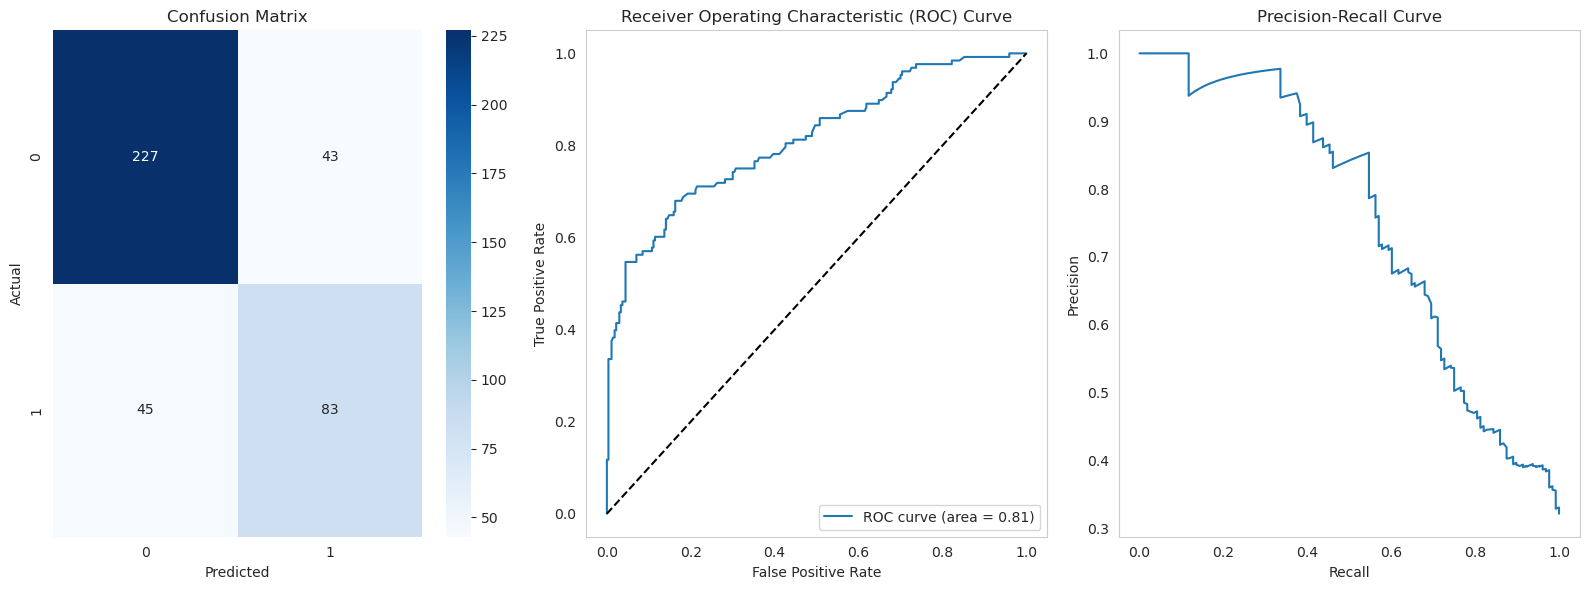

In [25]:
print("Logistic Regression Model")
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_test, y_pred_proba), 6))
visualize_performance(y_test, y_pred, y_pred_proba)

Model summary:
* The model performs well in predicting customers who do not buy travel insurance, with a high precision and recall.
* The performance for customers who buy travel insurance is lower, with precision and recall values around 0.65.
* The ROC curve shows that the model has a good overall performance in distinguishing between the two classes, with the ROC-AUC score of **0.812355**.

The Precision-Recall curve suggests that the model maintains a reasonable balance between precision and recall, although precision drops as recall increases.
In essence, the model is a good start, but we should try and improve precision and recall for the customers that bought insurance.

## Logistic Regression Model - Additional improvements
We will now attempt implementing a Logistic Regression with the following additions:
* Implement a `StackingClassifier()` using `LogisticRegression()` for prediction, `SVC()` and `RandomForestClassifier` for class imbalance handling
* Standardize the data using `StandardScaler()`
* Add non-linear spline features through `SplineTransformer()`
* Approximate the RBF kernel using `Nystroem()`
* Perform hyperparameter tuning for the regularization strength of the logistic regression final estimator

In [26]:
estimators = [
    ('logreg', LogisticRegression(penalty='l2', max_iter=5_000, C=1.0)),
    ('svc', SVC(probability=True, kernel='rbf', class_weight='balanced')),
    ('rf', RandomForestClassifier(class_weight='balanced'))
]

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('spline', SplineTransformer(n_knots=10, degree=3, include_bias=False)),
    ('nystroem', Nystroem(kernel="rbf", gamma=1.0, n_components=100, random_state=98)),
    ('stacking', StackingClassifier(estimators=estimators, final_estimator=LogisticRegression()))
])

param_grid = {
    'stacking__final_estimator__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

Logistic Regression Model v2: Stacking Classifier
Best Parameters: {'stacking__final_estimator__C': 0.1}
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       270
           1       0.80      0.59      0.68       128

    accuracy                           0.82       398
   macro avg       0.81      0.76      0.78       398
weighted avg       0.82      0.82      0.81       398

ROC-AUC Score: 0.820182


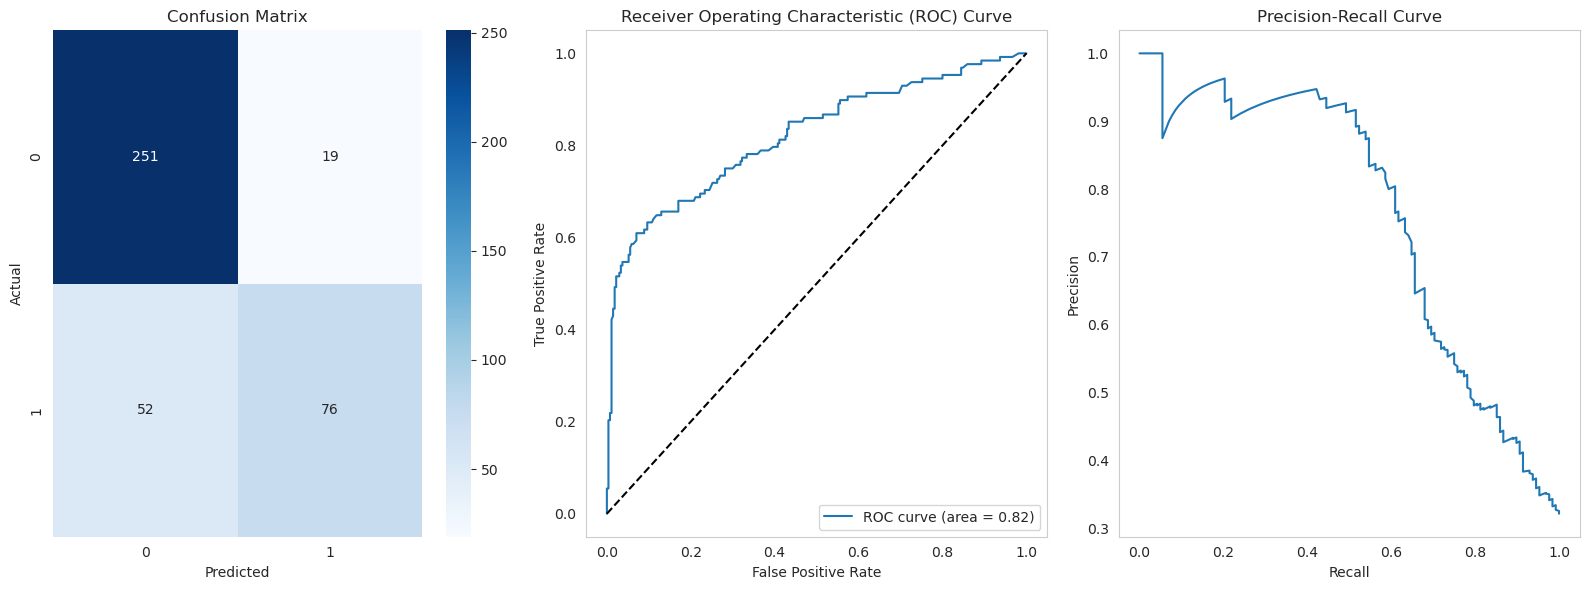

In [27]:
print("Logistic Regression Model v2: Stacking Classifier")
print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_test, y_pred_proba), 6))
visualize_performance(y_test, y_pred, y_pred_proba)

Model summary:
* Overall improved performance over the previous model, with an increased accuracy of **82%** and a higher ROC-AUC score.
* The performance for customers who buy travel insurance is lower, with precision and recall values around 0.65.
* Precision of predicted buyers increased, although recall decreased slightly.

# Summary
## Findings
The Logistic Regression Model with the Stacking Classifier seemed to work pretty well to predict insurance buyers with 82% accuracy, yet there is still room for improvement regarding recall.

Visualizations:

**Confusion Matrix:** The model performs very well in predicting customers who do not buy travel insurance and has a low false positive rate. However, the model's performance for customers who buy travel insurance is lower. While the model can correctly identify some customers who buy travel insurance, it misses a significant number of them as shown by the false negatives.

**ROC Curve:** The ROC curve shows a good balance between true positive rate and false positive rate.

**Precision-Recall curve:** reasonable balance between precision and recall, although precision drops as recall increases.

## Considerations
* Size of the dataset (less than 2000 customers).
* Cultural, economic differences (Indian customers, US application)
* Context of the dataset (COVID-19)

## Improvements for Future Studies
* Consider more advanced models for improving recall.
* Perform an expanded grid search with additional hyperparameters for better model accuracy.
* Explore more feature engineering options.